# The Tinbox Case

case description here

In [1]:
import inspect

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from rich import print

import probability_on_trial as pot

## Weight and Expected Weight of the evidence

<span style="color:red">Problem: probs. of evidence, are they dervied from prior probs. and the reliability of the evidence?</span>

Answer: these are computed using the current probabilites and likelihoods, P(E) = P(E|H)P(H) + P(E|~H)(1-P(H))

In the chunk below, we are testing the `expected_weight` function with dummy values. The `outcome_prior` is indifferent to the $3$ posteriors defined as tensors withing the list. `probs_of_evidence` is a tensor of probabilities of those pieces of evidence.

In [2]:
# values used in the illustration are meaningless

probs_of_evidence = torch.tensor([0.1, 0.5, 0.4])
outcome_prior = torch.tensor([0.25, 0.25, 0.25, 0.25])
posteriors = [
    torch.tensor([0.6, 0.2, 0.1, 0.1]),
    torch.tensor([0.3, 0.4, 0.1, 0.2]),
    torch.tensor([0.25, 0.35, 0.2, 0.2]),
]

posteriors = torch.stack(posteriors, dim=-2)
print(posteriors.shape)
# there are three distributions with four states

# first, let's see the docstring of weight
print(inspect.getdoc(pot.weight))

# calculate on a single distribtion:
single_weight = pot.weight(posteriors[0])
print(single_weight)
assert torch.allclose(single_weight, torch.tensor(0.2145), atol=0.01)

# calculate on a batch of distributions:
batched_weights = pot.weight(posteriors)
print(batched_weights)
assert torch.allclose(
    batched_weights, torch.tensor([0.2145, 0.0768, 0.0206]), atol=0.01
)

torch.Size([3, 4])

Calculates the weight of the posterior distribution.
The weight is defined as 1 - H(posterior) / H(prior)
where H is the entropy of the distribution.
    param: posterior: torch.Tensor - tensor of probabilities (not samples).
    Probabilities need to sum to 1 in dimension -1, can be batched in dimension -2.
    See test_weight.py for examples.

tensor(0.2145)

tensor([0.2145, 0.0768, 0.0206])

In [3]:
# Now expected weight
# see the function documentation for an explanation
print(inspect.getdoc(pot.expected_weight))

result = pot.expected_weight(probs_of_evidence, outcome_prior, posteriors)
print(result)

Compute the expected weight change given a prior distribution, posterior distributions,
and the probabilities of evidence.

The function evaluates how much the weight of evidence changes based on different
posterior distributions, adjusting for the probabilities of the evidence.

Args:
    probs_of_evidence (torch.Tensor): A tensor representing the likelihood of each evidence scenario.
    outcome_prior (torch.Tensor): A tensor representing the prior distribution over outcomes.
    posteriors (List): A list of tensors, each representing a posterior distribution.
    base (int, optional): The logarithmic base used in weight calculations (default: 2).

Returns:
    Dict: A dictionary containing the following elements:

    - **expected_weight** (`torch.Tensor`): The overall expected change in weight across possible
      evidence values, incorporating both prior information and posterior adjustments.

    - **weight_prior** (`torch.Tensor`): The weight of the prior distribution before observing any evidence.

    - **posterior_weights** (`torch.Tensor`): The computed weights of the posterior distributions.
      A posterior weight close to 1 indicates more certainty (lower entropy), whereas a value close
      to 0 suggests higher uncertainty.

    - **weight_changes** (`torch.Tensor`): The differences between posterior weights and the prior weight,
      quantifying how much each posterior deviates from the prior.

    - **weighted_weight_changes** (`torch.Tensor`): The `weight_changes` values scaled by their respective
      probabilities (`probs_of_evidence`), representing each piece of evidence's contribution to the
      overall expected weight change.

Mathematical Formulation:

{
    'expected_weight': tensor(0.0681),
    'weight_prior': tensor(0.),
    'posterior_weights': tensor([0.2145, 0.0768, 0.0206]),
    'weight_changes': tensor([0.2145, 0.0768, 0.0206]),
    'weighted_weight_changes': tensor([0.0215, 0.0384, 0.0082])
}

## Tinbox case, son not considered

The first model represents the case where we have 3 pieces of evidence: father's confession, angle of attack and fingerprints found on the tinbox. The only two possible hyphotesis about the perepetrator are: father did that, someone else did that, the son is not considered as a suspect.

By masking done within the model, we are able to extract three posterioros representing 3 possible scenerios: father's fingerprints were found, someone else's fingerprints were found, no fingerprints were found.

In [4]:
# set pyro seed

pr_father: float = 0.01  # the core defines point probabilities of some possible states
pr_confession_if_father = 0.4
pr_confession_if_not_father = 0.0001
father_fingerprints_if_father = 0.4
father_fingerprints_if_not_father = 0.1
other_fingerprints_if_father = 0.2
other_fingerprints_if_not_father = 0.4
angle_if_father = 0.4
angle_if_not_father = 0.5

pyro.set_rng_seed(42)


def tinbox_core_no_son(
    pr_father: float = pr_father,
    # the core defines point probabilities of some possible states
    pr_confession_if_father=0.4,
    pr_confession_if_not_father=0.0001,
    father_fingerprints_if_father=0.4,
    father_fingerprints_if_not_father=0.1,
    other_fingerprints_if_father=0.2,
    other_fingerprints_if_not_father=0.4,
    angle_if_father=0.4,
    angle_if_not_father=0.5,
    num_particles=3e4,  # should be wide uniform really
):

    # Simulating the scenario `num_particles` times
    with pyro.plate("inner_particles", size=num_particles):

        # Simulate whether the father is guilty (Bernoulli = binary outcome: guilty or not)
        father = pyro.sample(
            "father", dist.Bernoulli(pr_father)
        )  # 1 means guilty, 0 means not guilty

        # Calculate the probability of a confession based on whether the father is guilty or not
        prob_confession = pyro.deterministic(
            "prob_confession",
            father * pr_confession_if_father
            + (1 - father) * pr_confession_if_not_father,
        )
        # If the father is guilty, use pr_confession_if_father, otherwise use pr_confession_if_not_father

        # Simulate whether there is a confession (again, a binary outcome: confession or not)
        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        # Calculate the probability of finding the father's fingerprints based on guilt
        prob_father_fingerprints = pyro.deterministic(
            "prob_father_fingerprints",
            father * father_fingerprints_if_father
            + (1 - father) * father_fingerprints_if_not_father,
        )
        # If guilty, use father_fingerprints_if_father, otherwise use father_fingerprints_if_not_father

        # Simulate whether the father's fingerprints are found
        father_fingerprints = pyro.sample(
            "father_fingerprints", dist.Bernoulli(prob_father_fingerprints)
        )

        # Calculate the probability of finding other people's fingerprints based on guilt
        prob_other_fingerprints = pyro.deterministic(
            "prob_other_fingerprints",
            father * other_fingerprints_if_father
            + (1 - father) * other_fingerprints_if_not_father,
        )
        # If the father is guilty, it's less likely we find other people's fingerprints

        # Simulate whether other fingerprints are found
        other_fingerprints = pyro.sample(
            "other_fingerprints", dist.Bernoulli(prob_other_fingerprints)
        )

        # Calculate the probability of the evidence angle based on guilt
        angle_prob = pyro.deterministic(
            "angle_prob", father * angle_if_father + (1 - father) * angle_if_not_father
        )
        # If guilty, we use angle_if_father, otherwise we use angle_if_not_father

        # Simulate whether the evidence angle matches (binary outcome)
        angle = pyro.sample("angle", dist.Bernoulli(angle_prob))

        # a bit hacky, but we want to run it inside other models, so we
        # avoid running real inference here, using this poor man's
        # rejection sampling

        # The process below uses masking to generate different scenarios based on the evidence found

        # Mask 1: Evidence shows a confession, correct angle, and only father's fingerprints
        evidence_mask_father_fingerprint = (
            confession * angle * father_fingerprints * (1 - other_fingerprints)
        ).bool()
        # We want the scenario where the father confesses, the angle matches, and we only find his fingerprints

        # Mask 2: Evidence shows a confession and correct angle, but no fingerprints are found
        evidence_mask_no_fingerprint = (confession * angle).bool()
        # In this scenario, we care only about the confession and matching angle, not fingerprints

        # Mask 3: Evidence shows a confession, matching angle, but only other people's fingerprints are found
        evidence_mask_not_fathers_fingerprint = (
            confession * (1 - father_fingerprints) * other_fingerprints * angle
        ).bool()
        # In this scenario, we find only other fingerprints, not the father's, even though the confession and angle match

        #  Applying the masks:

        # Mask father's guilt based on the "father's fingerprint" scenario
        father_masked_fathers_fingerprint = pyro.deterministic(
            "father_masked_fingerprint",
            torch.where(
                evidence_mask_father_fingerprint, father, torch.tensor(float("nan"))
            ),
        )

        # Mask father's guilt based on the "no fingerprint" scenario
        father_masked_no_fingerpint = pyro.deterministic(
            "father_masked_no_fingerprint",
            torch.where(
                evidence_mask_no_fingerprint, father, torch.tensor(float("nan"))
            ),
        )

        # Mask father's guilt based on the "other people's fingerprints" scenario
        father_masked_not_fathers_fingerprint = pyro.deterministic(
            "father_masked_not_fathers_fingerprint",
            torch.where(
                evidence_mask_not_fathers_fingerprint,
                father,
                torch.tensor(float("nan")),
            ),
        )

    #  Calculate the posterior probabilities (the average probability of father being guilty)
    # based on the different scenarios

    # Posterior probability that the father is guilty given the first scenario (only father's fingerprints)
    posterior_father_fathers_fingerprint = pyro.deterministic(
        "posterior_father_fathers_fingerprint",
        torch.nanmean(father_masked_fathers_fingerprint, axis=0),
    )

    # Posterior probability that the father is guilty given the second scenario (no fingerprints)
    posterior_father_no_fingerprint = pyro.deterministic(
        "posterior_father_no_fingerprint",
        torch.nanmean(father_masked_no_fingerpint, axis=0),
    )

    # Posterior probability that the father is guilty given the third scenario (other people's fingerprints)
    posterior_father_not_fathers_fingerprint = pyro.deterministic(
        "posterior_father_not_fathers_fingerprint",
        torch.nanmean(father_masked_not_fathers_fingerprint, axis=0),
    )

    return {
        "posterior_father_fathers_fingerprint": posterior_father_fathers_fingerprint,
        "posterior_father_no_fingerprint": posterior_father_no_fingerprint,
        "posterior_father_not_fathers_fingerprint": posterior_father_not_fathers_fingerprint,
    }

### The graph of the tinbox case

The graph below represents the first model of the tinbox case.


- **father**: A Bernoulli random variable indicating whether the father is guilty.    
- **prob_confession, prob_father_fingerprints, prob_other_fingerprints, angle_prob**: These are deterministic nodes representing probabilities conditioned on the father's guilt.   
- **confession, father_fingerprints, other_fingerprints, angle**: These are sampled variables based on the previously calculated probabilities.    
- **father_masked_fingerprint, father_masked_not_fathers_fingerprint, father_masked_no_fingerprint**: Intermediate variables that represent the masked outcomes (based on certain evidence like fingerprints or confession).    
- **posterior_father_fathers_fingerprint, posterior_father_not_fathers_fingerprint, posterior_father_no_fingerprint**: These are the final outputs, representing posterior probabilities.    

/home/rafal/miniconda3/envs/mrbook/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


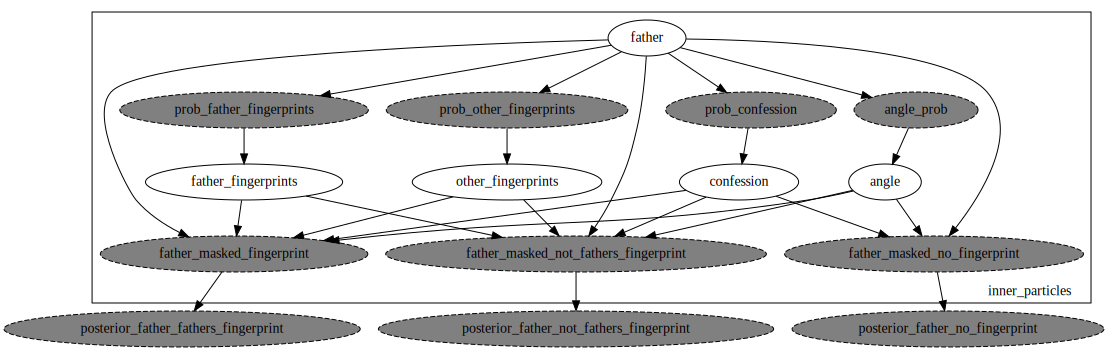

In [5]:
pyro.render_model(tinbox_core_no_son, render_deterministic=True)

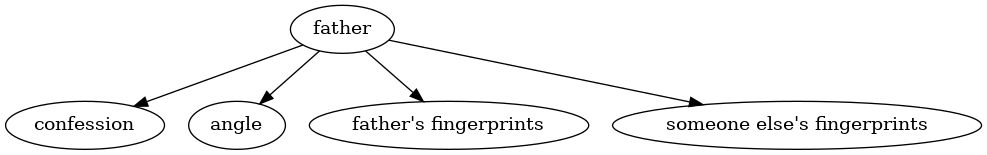

In [6]:
# simplistic DAG

# from graphviz import Digraph
# from IPython.display import Image, display

# dot = Digraph(comment="Modified Murder Case DAG with Other's Fingerprints")

# dot.node('father', 'Father')
# dot.node('confession', 'Confession')
# dot.node('angle', 'Angle')
# dot.node('father_fingerprints', 'Father\'s Fingerprints')
# dot.node('others_fingerprints', 'Other\'s Fingerprints')
# dot.node('posterior_father_fathers_fingerprint', 'Posterior Father\'s Fingerprints')
# dot.node('posterior_father_not_fathers_fingerprint', 'Posterior Other\'s Fingerprints')
# dot.node('posterior_father_no_fingerprint', 'Posterior No Fingerprints')


# dot.edge('father', 'father_fingerprints')
# dot.edge('father', 'others_fingerprints')
# dot.edge('father', 'confession')
# dot.edge('father', 'angle')

# dot.edge('father_fingerprints', 'posterior_father_fathers_fingerprint')
# dot.edge('father_fingerprints', 'posterior_father_not_fathers_fingerprint')
# dot.edge('others_fingerprints', 'posterior_father_not_fathers_fingerprint')
# dot.edge('others_fingerprints', 'posterior_father_fathers_fingerprint')

# dot.edge('confession', 'posterior_father_fathers_fingerprint')
# dot.edge('confession', 'posterior_father_not_fathers_fingerprint')
# dot.edge('confession', 'posterior_father_no_fingerprint')

# dot.edge('angle', 'posterior_father_fathers_fingerprint')
# dot.edge('angle', 'posterior_father_not_fathers_fingerprint')
# dot.edge('angle', 'posterior_father_no_fingerprint')

# png_path = dot.render('figures/dag_tinbox_father', format='png')
# display(Image(png_path))
# no posterior row version
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Modified Murder Case DAG with Other's Fingerprints")

dot.node("father", "father")
dot.node("confession", "confession")
dot.node("angle", "angle")
dot.node("father_fingerprints", "father's fingerprints")
dot.node("others_fingerprints", "someone else's fingerprints")

dot.edge("father", "father_fingerprints")
dot.edge("father", "others_fingerprints")
dot.edge("father", "confession")
dot.edge("father", "angle")


png_path = dot.render("figures/dag_tinbox_father", format="png")

display(Image(png_path))

Within this chunk we are running the model for `num_particles` times and printing the results of the posterior probabilities.

In [7]:
# extracting the posterior probabilities

with pyro.poutine.trace() as tr:
    pyro.set_rng_seed(42)
    tinbox_core_no_son(num_particles=1e6)

for key in tr.trace.nodes.keys():
    if key.startswith("posterior"):
        print(key, tr.trace.nodes[key]["value"])

posterior_father_fathers_fingerprint tensor(0.9941)

posterior_father_no_fingerprint tensor(0.9669)

posterior_father_not_fathers_fingerprint tensor(0.9214)

The following code calculates the expected weight by performing Bayesian inference using posterior probabilities derived from a probabilistic model. It starts by extracting posterior values of the father's guilt given different types of fingerprint evidence (no fingerprints, father's fingerprints, and others' fingerprints). Then, it uses these values to calculate prior probabilities and the likelihood of various pieces of evidence (fingerprints and no fingerprints) given the current belief in the father's guilt.

The posteriors, probs_of_evidence, and prior_now are later used to calculate the expected weight.

In [8]:
# Calculations necessary for the expected weight

#  Posterior of father's guilt given no fingerprints
father_posterior_no_fingerprint = torch.tensor(
    [
        1
        - tr.trace.nodes["posterior_father_no_fingerprint"][
            "value"
        ],  # Probability father is innocent
        tr.trace.nodes["posterior_father_no_fingerprint"][
            "value"
        ],  # Probability father is guilty
    ]
)

#  Posterior of father's guilt given his fingerprints are found
father_posterior_fathers_fingerprint = torch.tensor(
    [
        1 - tr.trace.nodes["posterior_father_fathers_fingerprint"]["value"],
        tr.trace.nodes["posterior_father_fathers_fingerprint"]["value"],
    ]
)

#  Posterior of father's guilt given other (non-father) fingerprints are found
father_posterior_others_fingerprint = torch.tensor(
    [
        1 - tr.trace.nodes["posterior_father_not_fathers_fingerprint"]["value"],
        tr.trace.nodes["posterior_father_not_fathers_fingerprint"]["value"],
    ]
)

print("posterior_father_no_fingerprint", father_posterior_no_fingerprint)
print("posterior_father_fathers_fingerprint", father_posterior_fathers_fingerprint)
print("posterior_father_not_fathers_fingerprint", father_posterior_others_fingerprint)

# the core that was used in the model before
pr_father: float = 0.8
pr_confession_if_father = 0.9
pr_confession_if_not_father = 0.01
father_fingerprints_if_father = 0.2
father_fingerprints_if_not_father = 0.1
other_fingerprints_if_father = 0.01
other_fingerprints_if_not_father = 0.2

# Current posterior probability of father's guilt given no fingerprint evidence
pr_father_now = tr.trace.nodes["posterior_father_no_fingerprint"][
    "value"
]  # father's guilt with no fingerprints evidence

father_prior_now = torch.tensor([1 - pr_father_now, pr_father_now])  # Updated prior
print("prior now", father_prior_now)

# Calculating the probability of finding the father's fingerprints, given the current belief in his guilt
pr_fathers_fingerprint_now = (
    pr_father_now * father_fingerprints_if_father
    + (1 - pr_father_now) * father_fingerprints_if_not_father
)
print("fathers", pr_fathers_fingerprint_now)

# Calculating the probability of finding other fingerprints given the current belief in father's guilt
pr_other_fingerprints_now = (
    pr_father_now * other_fingerprints_if_father
    + (1 - pr_father_now) * other_fingerprints_if_not_father
)
print("others", pr_other_fingerprints_now)

# Calculating the probability of finding no fingerprints at all
pr_no_fingerprints_now = 1 - pr_fathers_fingerprint_now - pr_other_fingerprints_now
print("none", pr_no_fingerprints_now)


# Creating a tensor containing the probabilities of different types of evidence (fingerprints or no fingerprints)
probs_of_evidence_no_son = torch.tensor(
    [pr_fathers_fingerprint_now, pr_other_fingerprints_now, pr_no_fingerprints_now]
)
print("probs_of_evidence_no_son", probs_of_evidence_no_son)

posterior_father_no_fingerprint tensor([0.0331, 0.9669])

posterior_father_fathers_fingerprint tensor([0.0059, 0.9941])

posterior_father_not_fathers_fingerprint tensor([0.0786, 0.9214])

prior now tensor([0.0331, 0.9669])

fathers tensor(0.1967)

others tensor(0.0163)

none tensor(0.7870)

probs_of_evidence_no_son tensor([0.1967, 0.0163, 0.7870])

In [9]:
# # Visualization that represents posterior probabilities

# labels = ['Father\'s fingerprints', 'Others\' fingerprints', 'No fingerprints']

# values = [father_posterior_fathers_fingerprint[1],  father_posterior_others_fingerprint[1], father_posterior_no_fingerprint[1]]

# fig, ax = plt.subplots()
# bars = ax.bar(labels, values, color= 'steelblue')

# for bar in bars:
#     yval = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# ax.set_ylabel("Father's guilt prob.")

# sns.despine()#ax.set_title('Posterior Probs. (no son scenario)')

# plt.savefig('figures/tinbox_posterior_probs_no_son.pdf')
# plt.show()

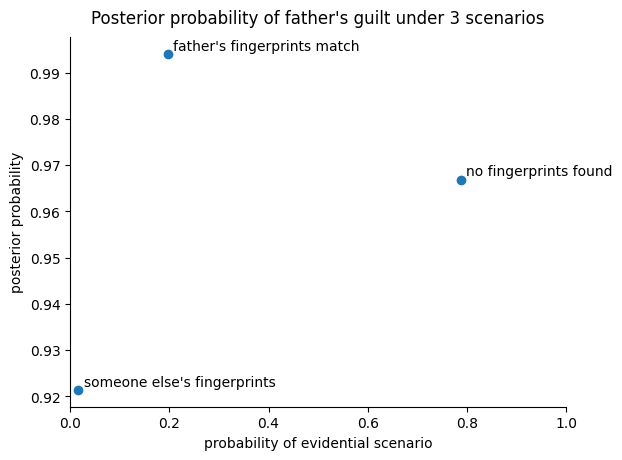

In [10]:
posterior_guilt_probs = [
    father_posterior_fathers_fingerprint[1],
    father_posterior_others_fingerprint[1],
    father_posterior_no_fingerprint[1],
]

labels = [
    "father's fingerprints match",
    "someone else's fingerprints",
    "no fingerprints found",
]
fig, ax = plt.subplots()
ax.scatter(probs_of_evidence_no_son, posterior_guilt_probs)
for i, label in enumerate(labels):
    ax.annotate(
        label,
        (probs_of_evidence_no_son[i], posterior_guilt_probs[i]),
        textcoords="offset points",
        xytext=(4, 3),
        ha="left",
        fontsize=10,
    )

ax.set_xlabel("probability of evidential scenario")
ax.set_title("Posterior probability of father's guilt under 3 scenarios", pad=10)
# pad title 2 mm

ax.set_ylabel("posterior probability")
plt.xlim(0, 1)

sns.despine()

plt.savefig("figures/tinbox_posterior_probs_no_son.pdf")
plt.show()

In [11]:
probs_of_evidence_no_son

tensor([0.1967, 0.0163, 0.7870])

In [12]:
posteriors = torch.stack(
    [
        father_posterior_fathers_fingerprint,
        father_posterior_others_fingerprint,
        father_posterior_no_fingerprint,
    ],
    dim=0,
)

print("posteriors now have shape", posteriors.shape)


expected_weights_no_son = pot.expected_weight(
    probs_of_evidence_no_son,
    father_prior_now,
    posteriors,
)


# posterior weights: A tensor of weights calculated for each of the posterior distributions. Each posterior represents a belief after observing some evidence
# weight changes: The difference between the weights of the posteriors and the prior
# weighted weight changes: The weight_changes values multiplied by the probabilities of the corresponding pieces of evidence

for key in expected_weights_no_son:
    print(key, expected_weights_no_son[key])

posteriors now have shape
torch.Size([3, 2])

expected_weight tensor(0.0279)

weight_prior tensor(0.7902)

posterior_weights tensor([0.9476, 0.6028, 0.7902])

weight_changes tensor([ 0.1574, -0.1875,  0.0000])

weighted_weight_changes tensor([ 0.0310, -0.0031,  0.0000])

add to the vis. below: probs_of_evidence_no_son tensor([0.1996, 0.0107, 0.7897])

Add a description and explanation of the calculations below:


In [13]:
# # Visualization of the expected weight calculation

# posterior_weights = expected_weights_no_son["posterior_weights"]
# weight_changes = expected_weights_no_son["weight_changes"]
# weighted_weight_changes = expected_weights_no_son["weighted_weight_changes"]

# print('Expected weight (no son):', expected_weights_no_son["expected_weight"])

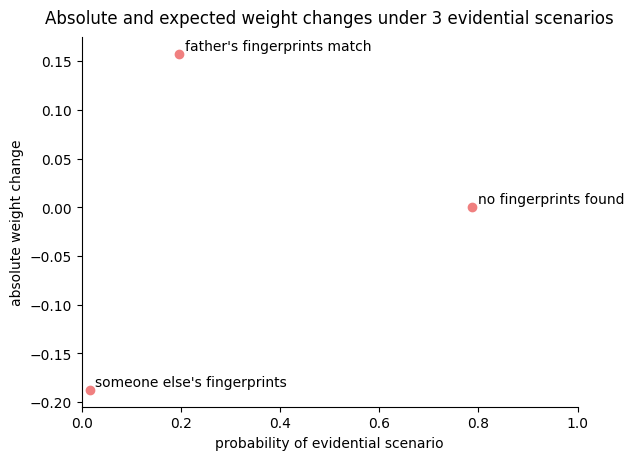

In [14]:
fig, ax = plt.subplots()
weight_changes = expected_weights_no_son["weight_changes"]
ax.scatter(probs_of_evidence_no_son, weight_changes, color="lightcoral")


for i, label in enumerate(labels):
    ax.annotate(
        label,
        (probs_of_evidence_no_son[i], weight_changes[i]),
        textcoords="offset points",
        xytext=(4, 3),
        ha="left",
        fontsize=10,
    )


first_key = list(expected_weights_no_son.keys())[0]
first_value = expected_weights_no_son[first_key].item()
rounded_value = round(first_value, 4)

ax.set_title(
    f"Absolute and expected weight changes under 3 evidential scenarios", pad=10
)
# TODO NIKODEM add text with calculations:
#  f"Expected weight of the evidence: FORMULA ... {rounded_value}"


# ax.set_title(f"Expected weight of the wvidence: {rounded_value}", pad=10)
ax.set_xlabel("probability of evidential scenario")
ax.set_ylabel("absolute weight change")
sns.despine()
plt.xlim(0, 1)

plt.savefig("figures/tinbox_posterior_weights_no_son.pdf")
plt.show()

In [15]:
# labels = ['Father\'s fingerprints', 'Others\' fingerprints', 'No fingerprints']

# fig, axs = plt.subplots(1, 2, figsize=(11, 5))

# axs[0].bar(labels, posterior_weights, color= 'lightblue')
# axs[0].set_title('Posterior Weights')
# axs[0].set_ylabel('Weight')
# for i, v in enumerate(posterior_weights):
#     axs[0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# axs[1].bar(labels, weighted_weight_changes, color='lightcoral')
# axs[1].set_title('Expected Weights') # Weighted Weight Changes
# axs[1].set_ylabel('Weighted Change')
# for i, v in enumerate(weighted_weight_changes):
#     axs[1].text(i, v, f"{v:.3f}", ha='center', va='bottom')

# # axs[1].bar(labels, weight_changes, color='lightgreen')
# # axs[1].set_title('Weight Changes (Posteriors - Prior)')
# # axs[1].set_ylabel('Weight Change')
# # for i, v in enumerate(weight_changes):
# #     axs[1].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# plt.tight_layout()
# plt.savefig('figures/tinbox_posterior_weights_no_son.pdf')
# plt.show()

## Tinbox case, son considered

We will follow here the same workflow as in the previous case, but now we will consider the son. Build the model, calculating the posterior and expected weight.

In [16]:
# set pyro seed
pyro.set_rng_seed(42)


def tinbox_core_son(
    pr_father: float = 0.5,
    pr_confession_if_father=0.4,
    pr_confession_if_son=0.4,  # Probability of confession if father is NOT guilty is 0.8 (higher), whereas in the previous model it was 0.01.
    father_fingerprints_if_father=0.4,
    father_fingerprints_if_son=0.1,
    son_fingerprints_if_father=0.1,  # This model introduces son’s fingerprints
    son_fingerprints_if_son=0.4,
    angle_if_father=0.3,
    angle_if_son=0.8,
    num_particles=3e4,  # should be wide uniform really
):
    with pyro.plate("inner_particles", size=num_particles):
        father = pyro.sample("father", dist.Bernoulli(pr_father))

        prob_confession = pyro.deterministic(
            "prob_confession",
            father * pr_confession_if_father + (1 - father) * pr_confession_if_son,
        )

        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        prob_father_fingerprints = pyro.deterministic(
            "prob_father_fingerprints",
            father * father_fingerprints_if_father
            + (1 - father) * father_fingerprints_if_son,
        )

        father_fingerprints = pyro.sample(
            "father_fingerprints", dist.Bernoulli(prob_father_fingerprints)
        )

        #  In this model, "other_fingerprints" refers to the son's fingerprints, not unrelated fingerprints like in the first model.
        prob_son_fingerprints = pyro.deterministic(
            "prob_son_fingerprints",
            father * son_fingerprints_if_father
            + (1 - father) * son_fingerprints_if_son,
        )  # The son's fingerprints are now incorporated.

        son_fingerprints = pyro.sample(
            "other_fingerprints", dist.Bernoulli(prob_son_fingerprints)
        )

        angle_prob = pyro.deterministic(
            "angle_prob", father * angle_if_father + (1 - father) * angle_if_son
        )

        angle = pyro.sample("angle", dist.Bernoulli(angle_prob))

        # a bit hacky, but we want to run it inside other models, so we
        # avoid running real inference here, using this poor man's
        # rejection sampling

        # Evidence masks remain similar to the first model:

        evidence_mask_father_fingerprint = (
            confession * angle * father_fingerprints * (1 - son_fingerprints)
        ).bool()

        evidence_mask_no_fingerprint = (confession * angle).bool()

        evidence_mask_son_fingerprint = (
            confession * (1 - father_fingerprints) * son_fingerprints * angle
        ).bool()

        father_masked_fathers_fingerprint = pyro.deterministic(
            "father_masked_fingerprint",
            torch.where(
                evidence_mask_father_fingerprint, father, torch.tensor(float("nan"))
            ),
        )

        father_masked_no_fingerpint = pyro.deterministic(
            "father_masked_no_fingerprint",
            torch.where(
                evidence_mask_no_fingerprint, father, torch.tensor(float("nan"))
            ),
        )

        father_masked_son_fingerprint = pyro.deterministic(
            "father_masked_son_fingerprint",
            torch.where(
                evidence_mask_son_fingerprint, father, torch.tensor(float("nan"))
            ),
        )

    posterior_father_fathers_fingerprint = pyro.deterministic(
        "posterior_father_fathers_fingerprint",
        torch.nanmean(father_masked_fathers_fingerprint, axis=0),
    )

    posterior_father_no_fingerprint = pyro.deterministic(
        "posterior_father_no_fingerprint",
        torch.nanmean(father_masked_no_fingerpint, axis=0),
    )

    posterior_father_son_fingerprint = pyro.deterministic(
        "posterior_father_son_fingerprint",
        torch.nanmean(father_masked_son_fingerprint, axis=0),
    )

/home/rafal/miniconda3/envs/mrbook/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


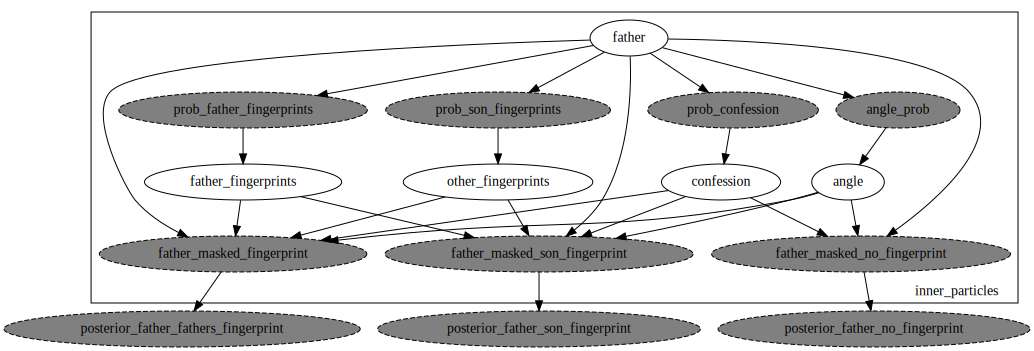

In [17]:
pyro.render_model(tinbox_core_son, render_deterministic=True)

In [18]:
with pyro.poutine.trace() as tr_son:
    pyro.set_rng_seed(42)
    tinbox_core_son(num_particles=1e6)

for key in tr_son.trace.nodes.keys():
    if key.startswith("posterior"):
        print(key, tr_son.trace.nodes[key]["value"])

posterior_father_fathers_fingerprint tensor(0.6922)

posterior_father_no_fingerprint tensor(0.2736)

posterior_father_son_fingerprint tensor(0.0593)

In [19]:
father_posterior_no_fingerprint = torch.tensor(
    [
        1 - tr_son.trace.nodes["posterior_father_no_fingerprint"]["value"],
        tr_son.trace.nodes["posterior_father_no_fingerprint"]["value"],
    ]
)
father_posterior_fathers_fingerprint = torch.tensor(
    [
        1 - tr_son.trace.nodes["posterior_father_fathers_fingerprint"]["value"],
        tr_son.trace.nodes["posterior_father_fathers_fingerprint"]["value"],
    ]
)
father_posterior_son_fingerprint = torch.tensor(
    [
        1 - tr_son.trace.nodes["posterior_father_son_fingerprint"]["value"],
        tr_son.trace.nodes["posterior_father_son_fingerprint"]["value"],
    ]
)

print("Posterior no fingerprints", father_posterior_no_fingerprint)
print("Posterior father's fingerprints", father_posterior_fathers_fingerprint)
print("Posterior other's fingerprints", father_posterior_son_fingerprint)

pr_father: float = 0.5
pr_confession_if_father = 0.4
pr_confession_if_son = 0.4  # Probability of confession if father is NOT guilty is 0.8 (higher), whereas in the previous model it was 0.01.
father_fingerprints_if_father = 0.4
father_fingerprints_if_son = 0.1
son_fingerprints_if_father = 0.1  # This model introduces son’s fingerprints
son_fingerprints_if_son = 0.4
angle_if_father = 0.3
angle_if_son = 0.8


pr_father_now = tr_son.trace.nodes["posterior_father_no_fingerprint"]["value"]

father_prior_now = torch.tensor([1 - pr_father_now, pr_father_now])

print("prior now", father_prior_now)

pr_fathers_fingerprint_now = (
    pr_father_now * father_fingerprints_if_father
    + (1 - pr_father_now) * father_fingerprints_if_son
)

print("fathers", pr_fathers_fingerprint_now)

pr_son_fingerprints_now = (
    pr_father_now * son_fingerprints_if_father
    + (1 - pr_father_now) * son_fingerprints_if_son
)

print("others", pr_other_fingerprints_now)

pr_no_fingerprints_now = 1 - pr_fathers_fingerprint_now - pr_son_fingerprints_now

print("none", pr_no_fingerprints_now)

probs_of_evidence_with_son = torch.tensor(
    [
        pr_fathers_fingerprint_now,
        pr_son_fingerprints_now,
        pr_no_fingerprints_now,
    ]
)
print("probs_of_evidence_with_son", probs_of_evidence_with_son)

Posterior no fingerprints tensor([0.7264, 0.2736])

Posterior father's fingerprints tensor([0.3078, 0.6922])

Posterior other's fingerprints tensor([0.9407, 0.0593])

prior now tensor([0.7264, 0.2736])

fathers tensor(0.1821)

others tensor(0.0163)

none tensor(0.5000)

probs_of_evidence_with_son tensor([0.1821, 0.3179, 0.5000])

/home/rafal/miniconda3/envs/mrbook/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


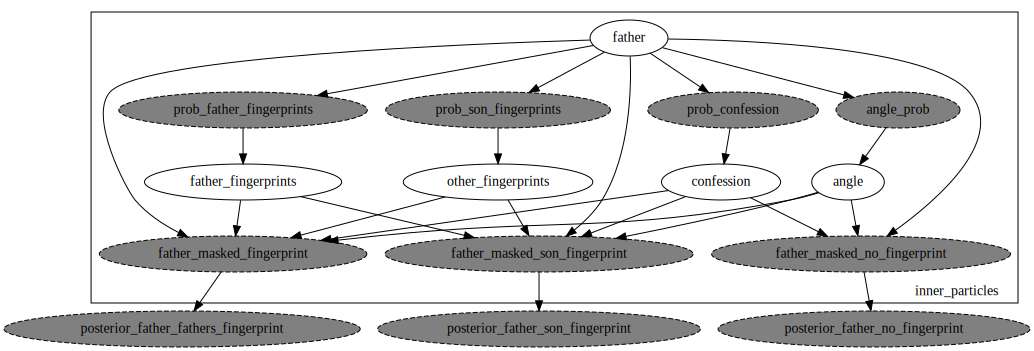

In [20]:
pyro.render_model(tinbox_core_son, render_deterministic=True)

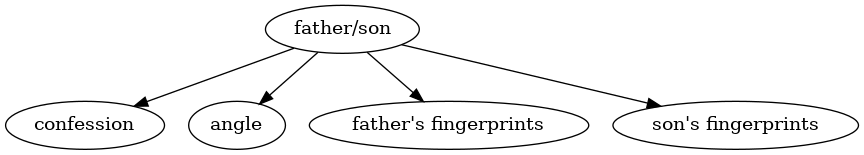

In [23]:
# simplistic DAG

# from graphviz import Digraph
# from IPython.display import Image, display

# dot = Digraph(comment="Modified Murder Case DAG with Other's Fingerprints")

# dot.node('father', 'Father')
# dot.node('confession', 'Confession')
# dot.node('angle', 'Angle')
# dot.node('father_fingerprints', 'Father\'s Fingerprints')
# dot.node('others_fingerprints', 'Other\'s Fingerprints')
# dot.node('posterior_father_fathers_fingerprint', 'Posterior Father\'s Fingerprints')
# dot.node('posterior_father_not_fathers_fingerprint', 'Posterior Other\'s Fingerprints')
# dot.node('posterior_father_no_fingerprint', 'Posterior No Fingerprints')


# dot.edge('father', 'father_fingerprints')
# dot.edge('father', 'others_fingerprints')
# dot.edge('father', 'confession')
# dot.edge('father', 'angle')

# dot.edge('father_fingerprints', 'posterior_father_fathers_fingerprint')
# dot.edge('father_fingerprints', 'posterior_father_not_fathers_fingerprint')
# dot.edge('others_fingerprints', 'posterior_father_not_fathers_fingerprint')
# dot.edge('others_fingerprints', 'posterior_father_fathers_fingerprint')

# dot.edge('confession', 'posterior_father_fathers_fingerprint')
# dot.edge('confession', 'posterior_father_not_fathers_fingerprint')
# dot.edge('confession', 'posterior_father_no_fingerprint')

# dot.edge('angle', 'posterior_father_fathers_fingerprint')
# dot.edge('angle', 'posterior_father_not_fathers_fingerprint')
# dot.edge('angle', 'posterior_father_no_fingerprint')

# png_path = dot.render('figures/dag_tinbox_father', format='png')
# display(Image(png_path))
# no posterior row version
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Modified Murder Case DAG with Other's Fingerprints")

dot.node("father/son", "father/son")
dot.node("confession", "confession")
dot.node("angle", "angle")
dot.node("father_fingerprints", "father's fingerprints")
dot.node("sons_fingerprints", "son's fingerprints")

dot.edge("father/son", "father_fingerprints")
dot.edge("father/son", "sons_fingerprints")
dot.edge("father/son", "confession")
dot.edge("father/son", "angle")


png_path = dot.render("figures/dag_tinbox_father_son_2", format="png")

display(Image(png_path))

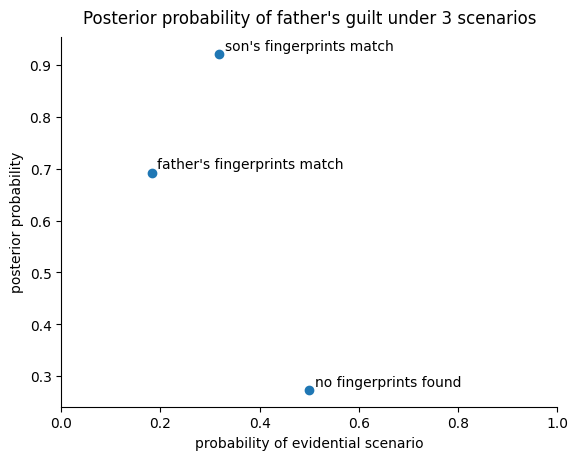

In [20]:
posterior_guilt_probs = [
    father_posterior_fathers_fingerprint[1],
    father_posterior_others_fingerprint[1],
    father_posterior_no_fingerprint[1],
]

labels = [
    "father's fingerprints match",
    "son's fingerprints match",
    "no fingerprints found",
]
fig, ax = plt.subplots()
ax.scatter(probs_of_evidence_with_son, posterior_guilt_probs)
for i, label in enumerate(labels):
    ax.annotate(
        label,
        (probs_of_evidence_with_son[i], posterior_guilt_probs[i]),
        textcoords="offset points",
        xytext=(4, 3),
        ha="left",
        fontsize=10,
    )

ax.set_xlabel("probability of evidential scenario")
ax.set_title("Posterior probability of father's guilt under 3 scenarios", pad=10)
ax.set_ylabel("posterior probability")
plt.xlim(0, 1)

sns.despine()

plt.savefig("figures/tinbox_posterior_probs_son.pdf")

plt.show()

In [20]:
posteriors = torch.stack(
    [
        father_posterior_fathers_fingerprint,
        father_posterior_others_fingerprint,
        father_posterior_no_fingerprint,
    ],
    dim=0,
)

print("Batched posteriors have the following shape", posteriors.shape)

expected_weights_with_son = pot.expected_weight(
    probs_of_evidence_with_son,
    father_prior_now,
    posteriors,
)

print(expected_weights_with_son)

Batched posteriors have the following shape
torch.Size([3, 2])

{
    'expected_weight': tensor(0.1348),
    'weight_prior': tensor(0.1535),
    'posterior_weights': tensor([0.1094, 0.6028, 0.1535]),
    'weight_changes': tensor([-0.0441,  0.4493,  0.0000]),
    'weighted_weight_changes': tensor([-0.0080,  0.1428,  0.0000])
}

Comparison of exp. weights, the scale, is 0.03 a significant difference?

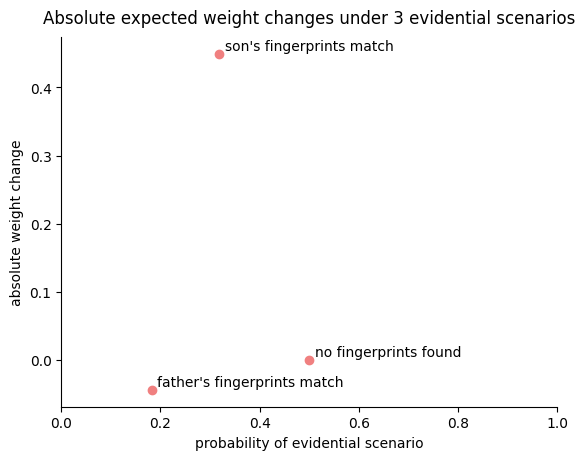

In [21]:
fig, ax = plt.subplots()
weight_changes = expected_weights_with_son["weight_changes"]
ax.scatter(probs_of_evidence_with_son, weight_changes, color="lightcoral")


for i, label in enumerate(labels):
    ax.annotate(
        label,
        (probs_of_evidence_with_son[i], weight_changes[i]),
        textcoords="offset points",
        xytext=(4, 3),
        ha="left",
        fontsize=10,
    )


first_key = list(expected_weights_with_son.keys())[0]
first_value = expected_weights_with_son[first_key].item()
rounded_value = round(first_value, 4)


# ax.set_title(f"Expected Weight of the Evidence: {rounded_value}", pad=10)
ax.set_title(f"Absolute expected weight changes under 3 evidential scenarios", pad=10)
ax.set_xlabel("probability of evidential scenario")
ax.set_ylabel("absolute weight change")
sns.despine()
plt.xlim(0, 1)


plt.savefig("figures/tinbox_posterior_weights_son.pdf")
plt.show()

## Digraph visualization of the DAG

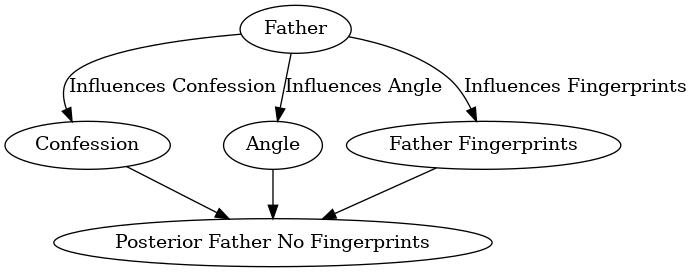

In [22]:
dot = Digraph(comment="Murder Case DAG")

dot.node("F", "Father")
dot.node("C", "Confession")
dot.node("A", "Angle")
dot.node("FF", "Father Fingerprints")
dot.node("P", "Posterior Father No Fingerprints")

dot.edge("F", "C", label="Influences Confession")
dot.edge("F", "A", label="Influences Angle")
dot.edge("F", "FF", label="Influences Fingerprints")
dot.edge("C", "P")
dot.edge("A", "P")
dot.edge("FF", "P")


png_path = dot.render("murder_case_dag", format="png")  # saving the PNG

display(Image(png_path))

![](tinbox_dagitty_plot.png){ fig-align="center" width="60%"}